# Homework #15: ***Computing resources***
## Author of the code:  *Xenia De Gracia Medina*.
## Date: *December 07, 2020*.

#### - **Purpose of the notebook:**
In this code, we try to forecast the flow values of the Verde River through the use of a linear regression model taking into account factors like the air temperature, soil moisture, and precipitation.

#### - **How you are generating forecasts and why?**
My forecast is done through the use of an autoregression of the daily flow values, converted to a logarithm scale. The reason for that procedure is due to the flow is not behaving linear, hence the logarithm scale has allowed us a better fit to the data.

#### - **A discussion of how you have done so far and how your forecasting has evolved over time.**
- I can tell that at the beginning I was not able to obtain ***data from a direct link to the server***, instead of that I had to download the file manually to my computer, and that didn't let other people run my code from their device without that file.
- Besides, on my first forecast, I was just obtaining flow values without taking into account other factors that could explain to myself the reason for the increase or the decrease of the flow. Now that I have learned to obtain data from ***different dataset sources***, I could make better decisions knowing the factors that could affect my model.
- I have seen the ***evolution on my coefficient of determination***. The new logarithm scale has developed on the model a coefficient of 0.92, however, my past models had a coefficient of determination of 0.32 and 0.63.
- ***Maps and plottings*** have allowed better visualization of the situation that we are studying, instead of seeing just a lot of numbers in a giant excel table from the firsts assignments.
- Finally, the improvement on the way of coding thanks to the ***PEP8 guidelines***, allow me to have a better presentation of my scripts making life easier for my future self and other users.

## 1. Update the necessary variables to make the code work

In [1]:
# NOTE Update this dates
end_date = '2020-12-05'

## 2. Import the tools we will use

In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime
import math
import json
import urllib.request as req
import urllib
import seaborn as sn
import xarray as xr
import seaborn as sn
import shapely
from shapely.geometry import Point

## 3. Getting the datasets to perform the modeling

## 3.1 Flow Data from USGS

Read the data from the website, into a pandas dataframe.

In [3]:
# %%
# Function to read the data from the USGS website, into a pandas dataframe.
def read_flow_data(end_date):

    """ Obtaining flow values from the USGS website.


    Parameters
    ----------
    end_date : updated date, to obtain the latest values.

    Returns
    ------
    data : dataframe with flow values
    flow_daily : dataframe with the datetime index and daily values
    flow_weekly : dataframe with the datetime index, resample to weekly values

    """

    Site = '09506000'
    Start = '1989-01-01'
    End = end_date
    url1 = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&' \
           'site_no='+Site+'&referred_module=sw&period=&' \
           'begin_date='+Start+'&end_date='+End

    print('The flow data is obtained  from: ', url1)
    print()

    data = pd.read_table(url1, sep='\t', skiprows=30,
                         names=['agency_cd', 'site_no', 'datetime', 'flow',
                                'code'],
                         parse_dates=['datetime'],
                         )

    # Expand the dates to year, month, day
    data['year'] = pd.DatetimeIndex(data['datetime']).year
    data['month'] = pd.DatetimeIndex(data['datetime']).month
    data['day'] = pd.DatetimeIndex(data['datetime']).day
    data['dayofweek'] = pd.DatetimeIndex(data['datetime']).dayofweek

    # Xenia: NOTE that Now Mondays are represented by "dayofweek = 0" and \
    # Sundays # are represented by "dayofweek = 6"

    # Aggregate datetime index to daily flow values and resample to weekly
    flow_daily = data.resample("D", on='datetime').min().round(2)
    flow_daily.insert(2, 'log_flow', np.log(flow_daily['flow']), True)
    flow_weekly = flow_daily.resample("W-SUN", on='datetime').min().round(2)

    # Adding timezone = UTC to the flow data, to join the Mesowest data after
    flow_daily.index = flow_daily.index.tz_localize(tz="UTC")
    flow_weekly.index = flow_weekly.index.tz_localize(tz="UTC")
    print(flow_daily)
    print()

    return data, flow_daily, flow_weekly

In [4]:
# Calling the function to get the Flow data from USGS
data, flow_daily, flow_weekly = read_flow_data(end_date)

The flow data is obtained  from:  https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=09506000&referred_module=sw&period=&begin_date=1989-01-01&end_date=2020-12-05

                          agency_cd  site_no  log_flow   datetime   flow code  \
datetime                                                                        
1989-01-01 00:00:00+00:00      USGS  9506000  5.332719 1989-01-01  207.0    A   
1989-01-02 00:00:00+00:00      USGS  9506000  5.323010 1989-01-02  205.0    A   
1989-01-03 00:00:00+00:00      USGS  9506000  5.323010 1989-01-03  205.0    A   
1989-01-04 00:00:00+00:00      USGS  9506000  5.446737 1989-01-04  232.0    A   
1989-01-05 00:00:00+00:00      USGS  9506000  5.556828 1989-01-05  259.0    A   
...                             ...      ...       ...        ...    ...  ...   
2020-12-01 00:00:00+00:00      USGS  9506000  5.068904 2020-12-01  159.0    P   
2020-12-02 00:00:00+00:00      USGS  9506000  5.056246 2020-12-02  157.0    P   
2020-12-03 

## 4. Autoregression modeling to obtain the flow forecast

In [5]:
# Step 1: setup the arrays you will build your model on. Building it
# based on the lagged timeseries.

flow_daily['flow_tm1'] = flow_daily['log_flow'].shift(1)
flow_daily['flow_tm2'] = flow_daily['log_flow'].shift(2)

# Step 2: Taking train data from August to December 2019 because it was a dry \
# year too.
train = flow_daily.loc["2019-08-22":"2019-12-12"][['log_flow', 'flow_tm1',
                                                   'flow_tm2']]
# This shows the start and end of the training data.
print("The training data was taken from: ", train.index.min(), "  to  ",
      train.index.max())
print()

# Xenia: Taking data from last 3 years to test (3 years=1095 days)
test = flow_daily[-1095:][['log_flow', 'flow_tm1', 'flow_tm2']]

# Step 3: Fit a linear regression model using sklearn
x = train['flow_tm1'].values.reshape(-1, 1)
y = train['log_flow'].values
# Xenia: Shorten the steps to create the regression model
model = LinearRegression().fit(x, y)

# Look at the results
# r^2 values
r_sq = model.score(x, y)
print('coefficient of determination:', np.round(r_sq, 2))

# Print the intercept and the slope
print('intercept:', np.round(model.intercept_, 2))
print('slope:', np.round(model.coef_, 2))

# Step 4 Make a prediction with your model
# Predict the model response for a  given flow value
q_pred_train = model.predict(train['flow_tm1'].values.reshape(-1, 1))
q_pred_test = model.predict(test['flow_tm1'].values.reshape(-1, 1))

# alternatively you can calcualte this yourself like this:
# Xenia: y = b + m(x)
q_pred = (model.intercept_) + (model.coef_ * train['flow_tm1'])
q_pred_W = q_pred.resample("W-SUN").min().round(2)
# Xenia: Printing the equation of the model
Equation = 'y = ' + str((model.intercept_).round(2)) + ' + ' + str(model.coef_.round(2)) + 'X'
print('The AR model equation is: ', Equation)
# Xenia: Printing my prediction value. (I used the mean value of the range.)
print('Prediction using equation from Linear Regression is:',
      np.exp(q_pred_W))
print(type(q_pred_W))

The training data was taken from:  2019-08-22 00:00:00+00:00   to   2019-12-12 00:00:00+00:00

coefficient of determination: 0.92
intercept: 0.18
slope: [0.97]
The AR model equation is:  y = 0.18 + [0.97]X
Prediction using equation from Linear Regression is: datetime
2019-08-25 00:00:00+00:00      31.816977
2019-09-01 00:00:00+00:00      34.123968
2019-09-08 00:00:00+00:00      54.054889
2019-09-15 00:00:00+00:00      51.418601
2019-09-22 00:00:00+00:00      51.418601
2019-09-29 00:00:00+00:00      54.054889
2019-10-06 00:00:00+00:00      75.944287
2019-10-13 00:00:00+00:00      80.640419
2019-10-20 00:00:00+00:00      76.707539
2019-10-27 00:00:00+00:00      80.640419
2019-11-03 00:00:00+00:00     100.484150
2019-11-10 00:00:00+00:00     126.469352
2019-11-17 00:00:00+00:00     132.953574
2019-11-24 00:00:00+00:00     144.026887
2019-12-01 00:00:00+00:00     181.272242
2019-12-08 00:00:00+00:00     437.029195
2019-12-15 00:00:00+00:00    1053.633557
Freq: W-SUN, Name: flow_tm1, dtype:

In [6]:
# Prediction of the q for just a single value
# Xenia: I used the mean value of the last 3 WEEKS to forecast the coming
# week.
# Xenia: I made the same to predict the second week value, but using the
# minimun flow of the data from the LAST week only.
last_week_flow = flow_daily['log_flow'][-21].mean()
last2_weeks_flow = flow_daily['log_flow'][-8].min()
prediction1stweek = math.exp(model.intercept_ + (model.coef_ * last_week_flow))
prediction2ndweek = math.exp(model.intercept_ + (model.coef_ * last2_weeks_flow))
# Xenia: Printing the equation of the model
Message1 = 'First week prediction based on my AR model: '+ str(np.round(prediction1stweek,2)) + ' ft3/s'
print(Message1)
print()

Message2 = 'Second week prediction based on my on my AR model: ' + str(np.round(prediction2ndweek,2)) + ' ft3/s'
print(Message2)
print()

First week prediction based on my AR model: 158.62 ft3/s

Second week prediction based on my on my AR model: 159.6 ft3/s



In [7]:
# To compare with my initial method using just average of the last weeks:

# AVERAGE FIRST WEEK FORECAST
flow_mean1 = np.round(((data['flow'].tail(21)).mean()), 2)
Message3 = 'The AVERAGE forecast for the FIRST week that comes is: ' + str(flow_mean1) + ' ft3/s'
print(Message3)
print()

# AVERAGE  SECOND WEEK FORECAST
flow_mean2 = np.round(((data['flow'].tail(14)).mean()), 2)
Message4 = 'The AVERAGE forecast for the SECOND week that comes is: ' + str(flow_mean2) + ' ft3/s'
print(Message4)
print()


The AVERAGE forecast for the FIRST week that comes is: 152.62 ft3/s

The AVERAGE forecast for the SECOND week that comes is: 154.0 ft3/s



In [8]:
# List of final message to print
MessageList = [Message1, Message2, Message3, Message4]
print(MessageList)

# Creating a dataframe from the MessageList
MessageDf = pd.DataFrame(MessageList)
MessageDf.to_csv('MessagePrinted.csv', index=False, header=False)


['First week prediction based on my AR model: 158.62 ft3/s', 'Second week prediction based on my on my AR model: 159.6 ft3/s', 'The AVERAGE forecast for the FIRST week that comes is: 152.62 ft3/s', 'The AVERAGE forecast for the SECOND week that comes is: 154.0 ft3/s']


## 5. Visualization of the data through plots

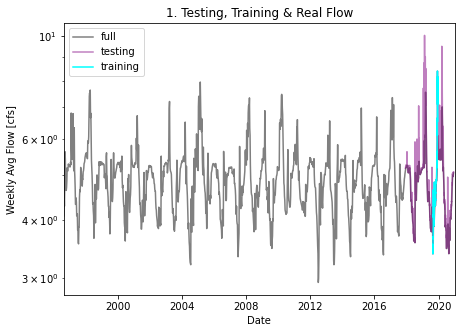

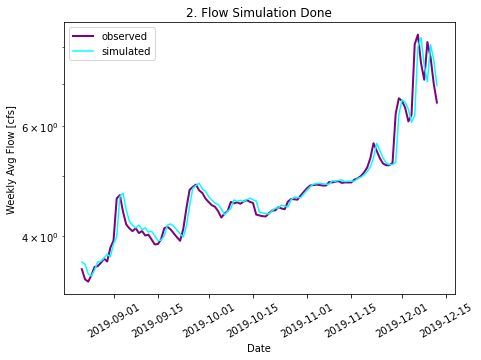

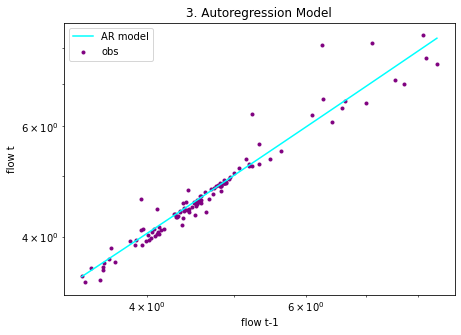

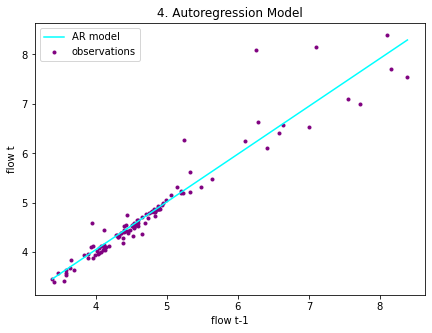

In [9]:
# PLOTS

# 1. Time series of flow values with the x axis range limited
fig, ax = plt.subplots()
ax.plot(flow_weekly['log_flow'], label='full', color='grey')
ax.plot(test['log_flow'], 'r:', label='testing', color='purple', linestyle='-',
        alpha=0.50, dash_capstyle='round')
ax.plot(train['log_flow'], 'r:', label='training', color='aqua', linestyle='-',
        alpha=1, dash_capstyle='round')
ax.set(title="1. Testing, Training & Real Flow", xlabel="Date",
       ylabel="Weekly Avg Flow [cfs]", yscale='log',
       xlim=[datetime.date(1996, 8, 24), datetime.date(2021, 1, 1)])
ax.legend()
fig.set_size_inches(7, 5)
fig.savefig("1. Testing, Training & Real Flow.png")

# 2. Line  plot comparison of predicted and observed flows
fig, ax = plt.subplots()
ax.plot(train['log_flow'], color='purple', linewidth=2, label='observed')
ax.plot(train.index, q_pred_train, color='aqua', linestyle='-',
        label='simulated')
ax.set(title="2. Flow Simulation Done", xlabel="Date",
       ylabel="Weekly Avg Flow [cfs]", yscale='log')

plt.xticks(rotation=30)
ax.legend()
# Xenia: Saving my plots
fig.set_size_inches(7, 5)
fig.savefig("2. Flow Simulation Done.png")

# 3. Scatter plot of t vs t-1 flow with log log axes
fig, ax = plt.subplots()
ax.scatter(train['flow_tm1'], train['log_flow'], marker='.',
           color='purple', label='obs')
ax.set(title="3. Autoregression Model", xlabel='flow t-1', ylabel='flow t',
       yscale='log', xscale='log')
ax.plot(np.sort(train['flow_tm1']), np.sort(q_pred_train), label='AR model',
        color='aqua')
ax.legend()
# Xenia: Saving my plots
fig.set_size_inches(7, 5)
fig.savefig("3. Autoregression Model.png")

# 4. Scatter plot of t vs t-1 flow with normal axes
fig, ax = plt.subplots()
ax.scatter(train['flow_tm1'], train['log_flow'], marker='.',
           color='purple', label='observations')
ax.set(title="4. Autoregression Model", xlabel='flow t-1', ylabel='flow t')
ax.plot(np.sort(train['flow_tm1']), np.sort(q_pred_train), label='AR model',
        color='aqua')
ax.legend()
# Xenia: Saving my plots
fig.set_size_inches(7, 5)
fig.savefig("4. Autoregression Model.png")

plt.show()